In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import os
import pathlib
import mne
from scipy.stats import sem
import seaborn as sns
from scipy.stats import t
from scipy.ndimage import gaussian_filter1d
from scipy.signal import convolve
from collections import defaultdict
from scipy.stats import linregress
from joblib import Parallel, delayed

In [2]:
plt.rcParams.update({
    'font.size': 14,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})

def add_subplot_label(ax, label, x=-.21, y=1.225):
    ax.text(x, y, label,  # Adjust left of y-axis
            transform=ax.transAxes,
            fontsize=26, va='top', ha='right')
    
colors0 = sns.color_palette("magma", n_colors=6)
colors1 = sns.color_palette("mako_r", n_colors=10)
pastel = sns.color_palette("Pastel1", n_colors=6)
adapt1 = sns.color_palette("Set1", n_colors=9)
adapt2 = sns.color_palette("Accent", n_colors=8)
colors4 = sns.color_palette("magma_r", n_colors=4)
colors5 = sns.color_palette("mako_r", n_colors=4)

colors2 = [pastel[0], pastel[3], adapt2[5]]
colors3 = [pastel[1], pastel[2], colors5[2]]
colors_implicit = [pastel[0], adapt2[5], pastel[3]]  # Baseline, Washout, Adaptation
colors_explicit = [pastel[1], colors5[2], pastel[2]]  # Baseline, Washout, Adaptation
colorbl = [adapt1[4], colors1[2]]

In [3]:
behav_df = pd.read_csv('./data/derivatives/behav_df_cleaned_new.csv')
behav_df = behav_df[behav_df['reach_vis_abs_err']<=60].reset_index(drop=True)

burst_df = pd.read_csv('./data/derivatives/burst_features.csv')

lookup_df = behav_df[["coh_cat", "perturb_cat", "trial", "block", "subject"]]

# Merge the two DataFrames based on the specified columns
df_burst_behav = burst_df.merge(lookup_df, on=["trial", "block", "subject"], how='left')

In [4]:
vis_epoch_lims=(-1.0, 2.0)
mot_epoch_lims=(-1.0, 1.5)
vis_plot_lims=(-0.5, 1.6)
mot_plot_lims=(-0.75, 1.25)

In [5]:
data_dir = './data/derivatives/beta_power'
files = [f for f in os.listdir(data_dir) if f.endswith('beta_power.pickle')]
motor_files = [f for f in files if 'motor-epo-beta_power.pickle' in f]
visual_files = [f for f in files if 'visual-epo-beta_power.pickle' in f]
subject_ids = behav_df['subject'].unique()

beta_power_visual_df = []
beta_power_motor_df = []

for selected_subject in subject_ids:
    motor_subject_files = [f for f in motor_files if selected_subject in f]
    visual_subject_files = [f for f in visual_files if selected_subject in f]

    if not motor_subject_files or not visual_subject_files:
        continue

    motor_meg_df_list = []
    visual_meg_df_list = []

    # Load motor files
    for fname in motor_subject_files:
        block = int(fname.split('-')[2])-2
        motor_epochs = pickle.Unpickler(open(os.path.join(data_dir, fname), "rb")).load()
        motor_time = motor_epochs['time']

        all_motor_data = {}
        for sensor, data in motor_epochs.items():
            if sensor == 'time':
                continue
            all_motor_data.setdefault(sensor, []).append(data)

        for sensor in all_motor_data:
            valid_arrays = [
                arr for arr in all_motor_data[sensor]
                if isinstance(arr, np.ndarray) and arr.ndim == 2 and arr.shape[1] == len(motor_time)
            ]
            all_motor_data[sensor] = np.concatenate(valid_arrays, axis=0) if valid_arrays else None
        all_motor_data = {k: v for k, v in all_motor_data.items() if v is not None}
        if not all_motor_data:
            continue

        motor_data_array = np.stack(list(all_motor_data.values()))
        motor_avg_per_trial = motor_data_array.mean(axis=0)

        motor_meg_df_list.append(pd.DataFrame({
            'subject': selected_subject,
            'block': block,
            'trial': np.arange(motor_avg_per_trial.shape[0]),
            'meg_signal': [arr for arr in motor_avg_per_trial]
        }))

    # Load visual files
    for fname in visual_subject_files:
        block = int(fname.split('-')[2])-2
        visual_epochs = pickle.Unpickler(open(os.path.join(data_dir, fname), "rb")).load()
        visual_time = visual_epochs['time']

        all_visual_data = {}
        for sensor, data in visual_epochs.items():
            if sensor == 'time':
                continue
            all_visual_data.setdefault(sensor, []).append(data)

        for sensor in all_visual_data:
            valid_arrays = [
                arr for arr in all_visual_data[sensor]
                if isinstance(arr, np.ndarray) and arr.ndim == 2 and arr.shape[1] == len(visual_time)
            ]
            all_visual_data[sensor] = np.concatenate(valid_arrays, axis=0) if valid_arrays else None
        all_visual_data = {k: v for k, v in all_visual_data.items() if v is not None}
        if not all_visual_data:
            continue

        visual_data_array = np.stack(list(all_visual_data.values()))
        visual_avg_per_trial = visual_data_array.mean(axis=0)
        
        visual_meg_df_list.append(pd.DataFrame({
            'subject': selected_subject,
            'block': block,
            'trial': np.arange(visual_avg_per_trial.shape[0]),
            'meg_signal': [arr for arr in visual_avg_per_trial]
        }))

    if not motor_meg_df_list or not visual_meg_df_list:
        continue

    motor_meg_df = pd.concat(motor_meg_df_list, ignore_index=True)
    visual_meg_df = pd.concat(visual_meg_df_list, ignore_index=True)

        
    # Behavior for subject
    behav_subject_data = behav_df[behav_df['subject'] == selected_subject].reset_index(drop=True)

    # Outlier rejection
    all_motor_values = np.concatenate(motor_meg_df['meg_signal'].values)
    mean_motor, std_motor = np.mean(all_motor_values), np.std(all_motor_values)
    all_visual_values = np.concatenate(visual_meg_df['meg_signal'].values)
    mean_visual, std_visual = np.mean(all_visual_values), np.std(all_visual_values)

    def is_motor_outlier(trial_signal):
        return np.any(np.abs(trial_signal - mean_motor) > 2.5 * std_motor)
    def is_visual_outlier(trial_signal):
        return np.any(np.abs(trial_signal - mean_visual) > 2.5 * std_visual)

    motor_meg_df = motor_meg_df[~motor_meg_df['meg_signal'].apply(is_motor_outlier)].reset_index(drop=True)
    visual_meg_df = visual_meg_df[~visual_meg_df['meg_signal'].apply(is_visual_outlier)].reset_index(drop=True)

    # Find common (block, trial)
    motor_keys = set(zip(motor_meg_df['block'], motor_meg_df['trial']))
    visual_keys = set(zip(visual_meg_df['block'], visual_meg_df['trial']))
    behav_keys = set(zip(behav_subject_data['block'], behav_subject_data['trial']))
    common_keys = sorted(motor_keys & visual_keys & behav_keys)

    motor_meg_df = motor_meg_df.set_index(['block', 'trial']).loc[common_keys].reset_index()
    visual_meg_df = visual_meg_df.set_index(['block', 'trial']).loc[common_keys].reset_index()
    behav_subject_data = behav_subject_data.set_index(['block', 'trial']).loc[common_keys].reset_index()
    
    merged_motor_df = pd.concat([behav_subject_data, motor_meg_df.drop(columns=['subject','block','trial'])], axis=1)
    merged_visual_df = pd.concat([behav_subject_data, visual_meg_df.drop(columns=['subject','block','trial'])], axis=1)

    beta_power_motor_df.append(merged_motor_df.reset_index(drop=True))
    beta_power_visual_df.append(merged_visual_df.reset_index(drop=True))

# Concatenate all subjects
beta_power_motor_df = pd.concat(beta_power_motor_df, ignore_index=True)
beta_power_visual_df = pd.concat(beta_power_visual_df, ignore_index=True)


In [6]:
def smooth_burst_rate(burst_rate, sigma):
    """Apply Gaussian smoothing with edge-padding to reduce edge artifacts."""
    size = int(6 * sigma) + 1
    x = np.linspace(-3, 3, size)
    kernel = np.exp(-0.5 * x**2)
    kernel /= kernel.sum()
    smoothed = np.convolve(burst_rate, kernel, mode='same')
    return smoothed


def process_trial(args):
    subject, block, trial, trial_df, behav_row, time_range, time_bin, smooth_sigma = args
    binned_counts = np.array([
        np.sum((trial_df['peak_time'] >= t) & (trial_df['peak_time'] < t + time_bin))
        for t in time_range
    ])
    burst_rate = smooth_burst_rate(binned_counts / time_bin, smooth_sigma)
    entry = behav_row.to_dict()
    entry.update({
        'meg_signal': burst_rate,
        'subject': subject,
        'block': block,
        'trial': trial
    })
    return entry


def make_burst_rate_df(df_burst_behav, behav_df, time_bin=0.025, smooth_sigma=1.5, epoch_lims=(-1.0, 1.5), n_jobs=-1):
    time_range = np.arange(epoch_lims[0], epoch_lims[1], time_bin)
    
    behav_lookup = behav_df.set_index(['subject', 'block', 'trial'])
    grouped = df_burst_behav.groupby(['subject', 'block', 'trial'])
    task_args = []

    for (subject, block, trial), group in grouped:
        key = (subject, block, trial)
        if key not in behav_lookup.index:
            continue
        behav_row = behav_lookup.loc[key]
        task_args.append((subject, block, trial, group, behav_row, time_range, time_bin, smooth_sigma))

    results = Parallel(n_jobs=n_jobs, prefer='processes', batch_size='auto')(
        delayed(process_trial)(args) for args in task_args
    )

    df = pd.DataFrame(results)
    
    return df, time_range


def compute_subject_averages(
    df, block_filter, time, visual_df, visual_time,
    cohcat=None, plot_lims=(-0.75, 1.25), baseline_lims=(-0.5, -0.25),
    exclude_subjects=None, return_subject_means=False
):
    plot_mask = (time >= plot_lims[0]) & (time <= plot_lims[1])
    baseline_mask = (visual_time >= baseline_lims[0]) & (visual_time <= baseline_lims[1])
    time_plot = time[plot_mask]
    all_subject_means = []

    result = {}
    group_subject_means = {}

    filtered_df = df[df['block'].isin(block_filter)]
    filtered_visual_df = visual_df[visual_df['block'].isin(block_filter)]

    if cohcat:
        filtered_df = filtered_df[filtered_df['coh_cat'] == cohcat]
        filtered_visual_df = filtered_visual_df[filtered_visual_df['coh_cat'] == cohcat]

    for group in filtered_df['group'].unique():
        group_df = filtered_df[filtered_df['group'] == group]
        visual_group_df = filtered_visual_df[filtered_visual_df['group'] == group]
        subject_arrays = []
        subject_ids = []
        subject_means = {}

        for subject in group_df['subject'].unique():
            if exclude_subjects and subject in exclude_subjects.get(group, []):
                continue

            subj_data = group_df[group_df['subject'] == subject]
            visual_subj_data = visual_group_df[visual_group_df['subject'] == subject]
            if subj_data.empty or visual_subj_data.empty:
                continue

            # Match trials
            motor_keys = set(zip(subj_data['block'], subj_data['trial']))
            visual_keys = set(zip(visual_subj_data['block'], visual_subj_data['trial']))
            common_keys = motor_keys & visual_keys

            motor_signals = []
            visual_signals = []
            for blk, trl in common_keys:
                motor_signal = subj_data[(subj_data['block'] == blk) & (subj_data['trial'] == trl)]['meg_signal']
                visual_signal = visual_subj_data[(visual_subj_data['block'] == blk) & (visual_subj_data['trial'] == trl)]['meg_signal']
                if not motor_signal.empty and not visual_signal.empty:
                    motor_signals.append(motor_signal.values[0])
                    visual_signals.append(visual_signal.values[0])

            if motor_signals and visual_signals:
                motor_avg = np.nanmean(np.stack(motor_signals), axis=0)
                visual_avg = np.nanmean(np.stack(visual_signals), axis=0)
                baseline = np.nanmean(visual_avg[baseline_mask])
                if not np.isnan(baseline):
                    normed = 100 * (motor_avg - baseline) / abs(baseline)
                    if not np.any(np.isnan(normed[plot_mask]) | np.isinf(normed[plot_mask])):
                        subject_arrays.append(normed[plot_mask])
                        subject_ids.append(subject)
                        subject_means[subject] = np.nanmean(normed[plot_mask])

        if subject_arrays:
            subject_arrays = np.array(subject_arrays)
            result[group] = subject_arrays
            group_subject_means[group] = subject_means

    if return_subject_means:
        return result, time_plot, dict(group_subject_means)
    else:
        return result, time_plot

In [7]:
phase_blocks = {'baseline': [0], 'adaptation': [1, 2, 3, 4, 5, 6], 'washout': [7]}
cohcats = ['zero', 'low', 'med', 'high']

def get_union_outliers(subject_means_by_condition, threshold=2.5):
    union_outliers = defaultdict(set)
    for cond, subject_means in subject_means_by_condition.items():
        for group, subj_dict in subject_means.items():
            means = np.array(list(subj_dict.values()))
            ids = list(subj_dict.keys())
            mu = np.nanmean(means)
            sigma = np.nanstd(means)
            outliers = [ids[i] for i, val in enumerate(means) if abs(val - mu) > threshold * sigma]
            union_outliers[group].update(outliers)
    return {group: list(subjs) for group, subjs in union_outliers.items()}


power_data={'vis': {}, 'mot': {}}
coh_power_data={'vis': {}, 'mot': {}}

# VISUAL: detect outliers across phases
# vis_phase_subject_means = {}
# for phase in phase_blocks:
#     _, _, subject_means = compute_subject_averages(
#         beta_power_visual_df, phase_blocks[phase], visual_time, beta_power_visual_df, visual_time,
#         plot_lims=vis_plot_lims, return_subject_means=True
#     )
#     vis_phase_subject_means[phase] = subject_means
# vis_phase_outliers = get_union_outliers(vis_phase_subject_means)

for phase in phase_blocks:
    power_data['vis'][phase], vis_plot_time = compute_subject_averages(
        beta_power_visual_df, phase_blocks[phase], visual_time, beta_power_visual_df, visual_time,
        plot_lims=vis_plot_lims#, exclude_subjects=vis_phase_outliers
    )

# MOTOR: detect outliers across phases
# mot_phase_subject_means = {}
# for phase in phase_blocks:
#     _, _, subject_means = compute_subject_averages(
#         beta_power_motor_df, phase_blocks[phase], motor_time, beta_power_visual_df, visual_time,
#         plot_lims=mot_plot_lims, return_subject_means=True
#     )
#     mot_phase_subject_means[phase] = subject_means
# mot_phase_outliers = get_union_outliers(mot_phase_subject_means)

for phase in phase_blocks:
    power_data['mot'][phase], mot_plot_time = compute_subject_averages(
        beta_power_motor_df, phase_blocks[phase], motor_time, beta_power_visual_df, visual_time,
        plot_lims=mot_plot_lims#, exclude_subjects=mot_phase_outliers
    )

# ----- COHERENCE ANALYSIS -----
# VISUAL: detect outliers across cohcats
# vis_coh_subject_means = {}
# for cohcat in cohcats:
#     _, _, subject_means = compute_subject_averages(
#         beta_power_visual_df, phase_blocks['adaptation'], visual_time, beta_power_visual_df, visual_time,
#         cohcat=cohcat, plot_lims=vis_plot_lims, return_subject_means=True
#     )
#     vis_coh_subject_means[cohcat] = subject_means
# vis_coh_outliers = get_union_outliers(vis_coh_subject_means)

for cohcat in cohcats:
    coh_power_data['vis'][cohcat], _ = compute_subject_averages(
        beta_power_visual_df, phase_blocks['adaptation'], visual_time, beta_power_visual_df, visual_time,
        cohcat=cohcat, plot_lims=vis_plot_lims#, exclude_subjects=vis_coh_outliers
    )

# MOTOR: detect outliers across cohcats
# mot_coh_subject_means = {}
# for cohcat in cohcats:
#     _, _, subject_means = compute_subject_averages(
#         beta_power_motor_df, phase_blocks['adaptation'], motor_time, beta_power_visual_df, visual_time,
#         cohcat=cohcat, plot_lims=mot_plot_lims, return_subject_means=True
#     )
#     mot_coh_subject_means[cohcat] = subject_means
# mot_coh_outliers = get_union_outliers(mot_coh_subject_means)

for cohcat in cohcats:
    coh_power_data['mot'][cohcat], _ = compute_subject_averages(
        beta_power_motor_df, phase_blocks['adaptation'], motor_time, beta_power_visual_df, visual_time,
        cohcat=cohcat, plot_lims=mot_plot_lims#, exclude_subjects=mot_coh_outliers
    )

power_time_plots = {'vis': vis_plot_time, 'mot': mot_plot_time}

In [8]:
df_visual = df_burst_behav[df_burst_behav['epoch'] == 'vis']
df_motor = df_burst_behav[df_burst_behav['epoch'] == 'mot']

In [9]:
def get_union_outliers(subject_means_by_condition, threshold=2.5):
    union_outliers = defaultdict(set)
    for cond, subject_means in subject_means_by_condition.items():
        for group, subj_dict in subject_means.items():
            means = np.array(list(subj_dict.values()))
            ids = list(subj_dict.keys())
            mu = np.nanmean(means)
            sigma = np.nanstd(means)
            outliers = [ids[i] for i, val in enumerate(means) if abs(val - mu) > threshold * sigma]
            union_outliers[group].update(outliers)
    return {group: list(subjs) for group, subjs in union_outliers.items()}

burst_rate_visual_df, visual_time = make_burst_rate_df(df_visual, behav_df, epoch_lims=vis_epoch_lims)
burst_rate_motor_df, motor_time = make_burst_rate_df(df_motor, behav_df, epoch_lims=mot_epoch_lims)

burst_data = {'vis': {}, 'mot': {}}
coh_burst_data = {'vis': {}, 'mot': {}}

# ----- PHASE-WISE ANALYSIS -----
# VISUAL: detect outliers across phases
# vis_phase_subject_means = {}
# for phase in phase_blocks:
#     _, _, subject_means = compute_subject_averages(
#         burst_rate_visual_df, phase_blocks[phase], visual_time, burst_rate_visual_df, visual_time,
#         plot_lims=vis_plot_lims, return_subject_means=True
#     )
#     vis_phase_subject_means[phase] = subject_means
# vis_phase_outliers = get_union_outliers(vis_phase_subject_means)

for phase in phase_blocks:
    burst_data['vis'][phase], vis_plot_time = compute_subject_averages(
        burst_rate_visual_df, phase_blocks[phase], visual_time, burst_rate_visual_df, visual_time,
        plot_lims=vis_plot_lims#, exclude_subjects=vis_phase_outliers
    )

# MOTOR: detect outliers across phases
# mot_phase_subject_means = {}
# for phase in phase_blocks:
#     _, _, subject_means = compute_subject_averages(
#         burst_rate_motor_df, phase_blocks[phase], motor_time, burst_rate_visual_df, visual_time,
#         plot_lims=mot_plot_lims, return_subject_means=True
#     )
#     mot_phase_subject_means[phase] = subject_means
# mot_phase_outliers = get_union_outliers(mot_phase_subject_means)

for phase in phase_blocks:
    burst_data['mot'][phase], mot_plot_time = compute_subject_averages(
        burst_rate_motor_df, phase_blocks[phase], motor_time, burst_rate_visual_df, visual_time,
        plot_lims=mot_plot_lims#, exclude_subjects=mot_phase_outliers
    )

# ----- COHERENCE ANALYSIS -----
# VISUAL: detect outliers across cohcats
# vis_coh_subject_means = {}
# for cohcat in cohcats:
#     _, _, subject_means = compute_subject_averages(
#         burst_rate_visual_df, phase_blocks['adaptation'], visual_time, burst_rate_visual_df, visual_time,
#         cohcat=cohcat, plot_lims=vis_plot_lims, return_subject_means=True
#     )
#     vis_coh_subject_means[cohcat] = subject_means
# vis_coh_outliers = get_union_outliers(vis_coh_subject_means)

for cohcat in cohcats:
    coh_burst_data['vis'][cohcat], _ = compute_subject_averages(
        burst_rate_visual_df, phase_blocks['adaptation'], visual_time, burst_rate_visual_df, visual_time,
        cohcat=cohcat, plot_lims=vis_plot_lims#, exclude_subjects=vis_coh_outliers
    )

# MOTOR: detect outliers across cohcats
# mot_coh_subject_means = {}
# for cohcat in cohcats:
#     _, _, subject_means = compute_subject_averages(
#         burst_rate_motor_df, phase_blocks['adaptation'], motor_time, burst_rate_visual_df, visual_time,
#         cohcat=cohcat, plot_lims=mot_plot_lims, return_subject_means=True
#     )
#     mot_coh_subject_means[cohcat] = subject_means
# mot_coh_outliers = get_union_outliers(mot_coh_subject_means)

for cohcat in cohcats:
    coh_burst_data['mot'][cohcat], _ = compute_subject_averages(
        burst_rate_motor_df, phase_blocks['adaptation'], motor_time, burst_rate_visual_df, visual_time,
        cohcat=cohcat, plot_lims=mot_plot_lims#, exclude_subjects=mot_coh_outliers
    )

rate_time_plots = {'vis': vis_plot_time, 'mot': mot_plot_time}


In [10]:
def plot_and_cluster_data_between_group(ax, time_range, data, colors, title, xlabel, ylabel, verbose=True):
    data_masked = [d[:, :len(time_range)] for d in data]
    implicit_data, explicit_data = data_masked  

    plotted_max = -np.inf
    for i, (name, d) in enumerate(zip(['Implicit', 'Explicit'], data_masked)):
        mean_curve = np.nanmean(d, axis=0)
        sem_curve = np.nanstd(d, axis=0) / np.sqrt(np.sum(~np.isnan(d), axis=0))
        ax.plot(time_range, mean_curve, label=name, color=colors[i], linewidth=3)
        ax.fill_between(time_range, mean_curve - sem_curve, mean_curve + sem_curve, alpha=0.2, color=colors[i])
        plotted_max = max(plotted_max, np.nanmax(mean_curve + sem_curve))

    # Cluster-based permutation test
    X = [explicit_data, implicit_data]
    T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(
        X,
        n_permutations=1000,
        stat_fun=mne.stats.ttest_ind_no_p,  # for independent samples
        tail=0,
        threshold=dict(start=0, step=0.01),
        out_type='mask',
        n_jobs=-1,
        verbose=verbose
    )

    sig_slices = [clusters[i] for i in range(len(cluster_p_values)) if cluster_p_values[i] < 0.05]
    
    if len(sig_slices) > 0:
        print(f"Significant clusters found!")
        y_marker = plotted_max + 0.05 * np.abs(plotted_max)  # Add 5% headroom
        for s in sig_slices:
            sig_indices = np.arange(s.start, s.stop)
            ax.plot(time_range[sig_indices], [y_marker] * len(sig_indices), '.', color='red', markersize=4, alpha=0.8)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(loc='lower left')

def plot_and_cluster_data_blocktype_within_group(ax, time_range, data, colors, title, xlabel, ylabel, verbose=True):
    data_masked = [d[:, :len(time_range)] for d in data]
    condition_names = ["Baseline", "Adaptation", "Washout"]
    plotted_max = -np.inf

    for i, (name, d) in enumerate(zip(condition_names, data_masked)):
        mean_curve = np.nanmean(d, axis=0)
        sem_curve = np.nanstd(d, axis=0) / np.sqrt(np.sum(~np.isnan(d), axis=0))
        ax.plot(time_range, mean_curve, label=name, color=colors[i], linewidth=3)
        ax.fill_between(time_range, mean_curve - sem_curve, mean_curve + sem_curve, alpha=0.2, color=colors[i])
        plotted_max = max(plotted_max, np.nanmax(mean_curve + sem_curve))

    # Cluster-based permutation test
    X = np.stack(data_masked, axis=1)
    factor_levels = [3]
    effects = 'A'
    F_vals, p_vals = mne.stats.f_mway_rm(X, factor_levels, effects=effects)

    X_reshaped = np.concatenate([X[:, i, :] for i in range(X.shape[1])], axis=0)
    condition_inds = np.repeat(np.arange(3), X.shape[0])

    T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(
        [X_reshaped[condition_inds == i] for i in range(3)],
        n_permutations=10000,
        stat_fun=None,  # default f_oneway
        threshold=None,
        tail=1,
        out_type='mask',
        n_jobs=-1,
        verbose=verbose
    )

    sig_slices = [clusters[i][0] for i in range(len(cluster_p_values)) if cluster_p_values[i] < 0.05]
    
    if sig_slices:
        print("Significant clusters found!")
        y_marker = plotted_max + 0.05 * np.abs(plotted_max)
        for s in sig_slices:
            sig_indices = np.arange(s.start, s.stop)
            ax.plot(time_range[sig_indices], [y_marker] * len(sig_indices), '.', color='red', markersize=4, alpha=0.8)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(loc='lower right')

def plot_and_cluster_data_coh(ax, time_range, data, colors, title, xlabel, ylabel, verbose=True):
    data_masked = [d[:, :len(time_range)] for d in data]
    coherence_names = ["Zero", "Low", "Medium", "High"]
    coh_levels = np.array([0, 1, 2, 3])
    plotted_max = -np.inf

    for i, (name, d) in enumerate(zip(coherence_names, data_masked)):
        mean_curve = np.nanmean(d, axis=0)
        sem_curve = sem(d, axis=0, nan_policy='omit')
        ax.plot(time_range, mean_curve, label=name, color=colors[i], linewidth=3)
        ax.fill_between(time_range, mean_curve - sem_curve, mean_curve + sem_curve, alpha=0.2, color=colors[i])
        plotted_max = max(plotted_max, np.nanmax(mean_curve + sem_curve))

    # Shape: (n_subjects, n_conditions, n_times)
    X = np.stack(data_masked, axis=1)
    n_subjects, _, n_times = X.shape
    slopes = np.empty((n_subjects, n_times))

    for subj in range(n_subjects):
        for t in range(n_times):
            y = X[subj, :, t]
            slope, _, _, _, _ = linregress(coh_levels, y)
            slopes[subj, t] = slope

    T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_1samp_test(
        slopes,
        n_permutations=10000,
        tail=0,
        threshold=None,
        out_type='mask',
        n_jobs=-1,
        verbose=verbose
    )

    sig_slices = [clusters[i][0] for i in range(len(cluster_p_values)) if cluster_p_values[i] < 0.05]

    if sig_slices:
        print("Significant clusters found!")
        y_marker = plotted_max + 0.05 * np.abs(plotted_max)
        for s in sig_slices:
            sig_indices = np.arange(s.start, s.stop)
            ax.plot(time_range[sig_indices], [y_marker] * len(sig_indices), '.', color='red', markersize=4, alpha=0.8)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(loc='lower right')

/home/bonaiuto/miniconda3/envs/explicit_implicit_bursts/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Significant clusters found!


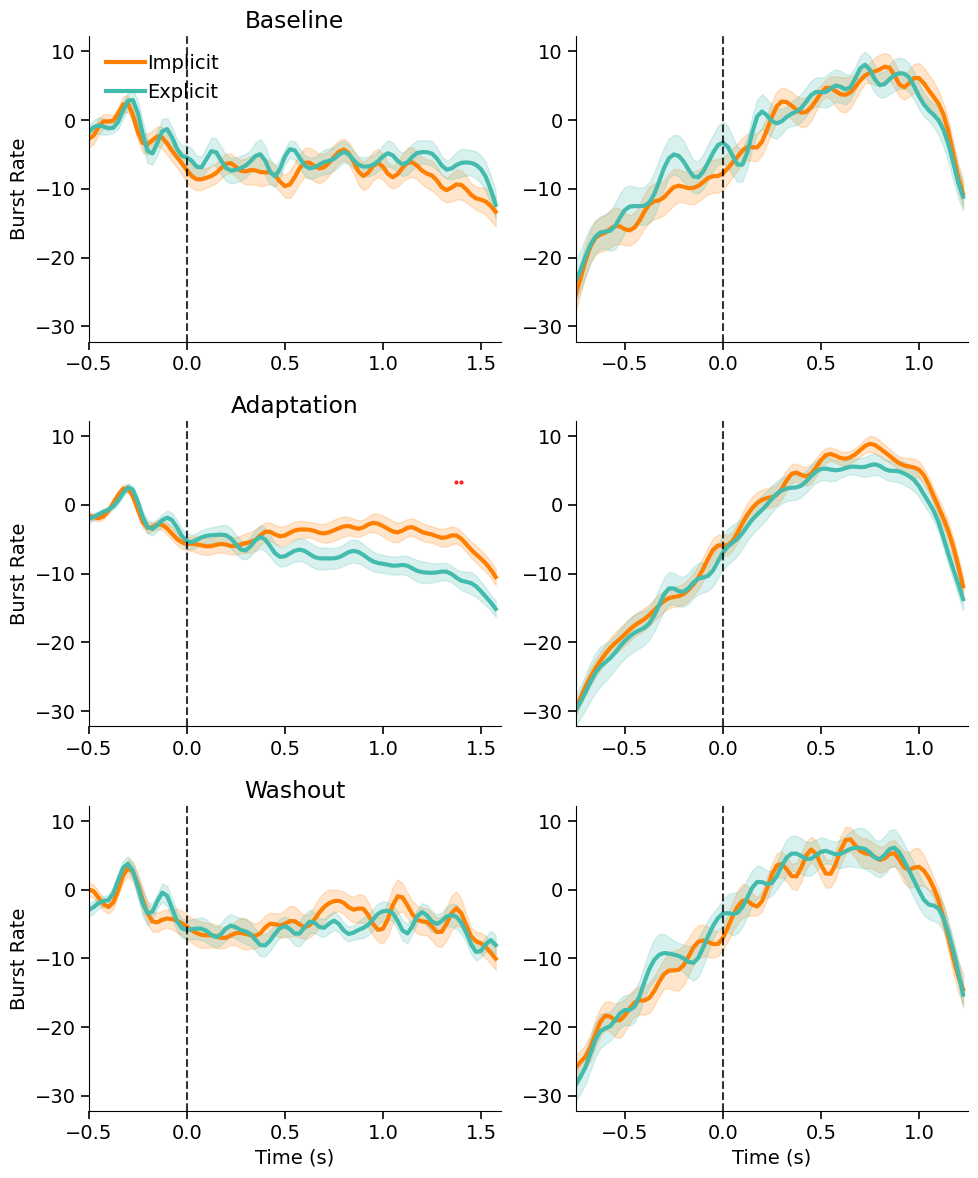

In [11]:
phases = ['baseline', 'adaptation', 'washout']
plot_lims = {'vis': (-0.5, 1.6), 'mot': (-0.75, 1.25)}
durations = {k: plot_lims[k][1] - plot_lims[k][0] for k in ['vis', 'mot']}
total_width = durations['vis'] + durations['mot']
width_ratios = [durations['vis'] / total_width, durations['mot'] / total_width]

# === Compute ylims from mean ± SEM ===
means = []
sems = []
for epoch in ['vis', 'mot']:
    for phase in phases:
        data = burst_data[epoch][phase]
        imp_mean = np.nanmean(data['Implicit'], axis=0)
        exp_mean = np.nanmean(data['Explicit'], axis=0)
        imp_sem = sem(data['Implicit'], axis=0, nan_policy='omit')
        exp_sem = sem(data['Explicit'], axis=0, nan_policy='omit')
        means.extend([*imp_mean, *exp_mean])
        sems.extend([*imp_sem, *exp_sem])

means = np.array(means)
sems = np.array(sems)
range_margin = 0.05 * (np.max(means + sems) - np.min(means - sems))
ylims = (
    np.min(means - sems),
    np.max(means + sems) + range_margin
)

# === Plotting ===
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(3, 2, width_ratios=width_ratios)
axes = {}

for i, phase in enumerate(phases):
    for j, epoch in enumerate(['vis', 'mot']):
        ax = fig.add_subplot(gs[i, j])
        axes[(phase, epoch)] = ax
        data = [
            burst_data[epoch][phase]['Implicit'],
            burst_data[epoch][phase]['Explicit']
        ]
        ylabel = "Burst Rate" if j == 0 else ""
        xlabel = "Time (s)" if i == 2 else ""
        title = f"{phase.capitalize()}" if j == 0 else ""
        plot_and_cluster_data_between_group(
            ax, rate_time_plots[epoch], data,
            colorbl, title, xlabel, ylabel,
            verbose=False
        )
        ax.set_xlim(*plot_lims[epoch])
        ax.set_ylim(ylims)

axes[('baseline', 'vis')].legend(loc='upper left')
for (phase, epoch), ax in axes.items():
    if not (phase == 'baseline' and epoch == 'vis'):
        ax.get_legend().remove()
    ax.axvline(0, linestyle='--', color='black', alpha=0.8)

plt.tight_layout()
# plt.savefig(f'./figures/{pc}_q{q+1}_burst_rate_grid.pdf', format='pdf', bbox_inches='tight', dpi=600)
# plt.close()


Significant clusters found!


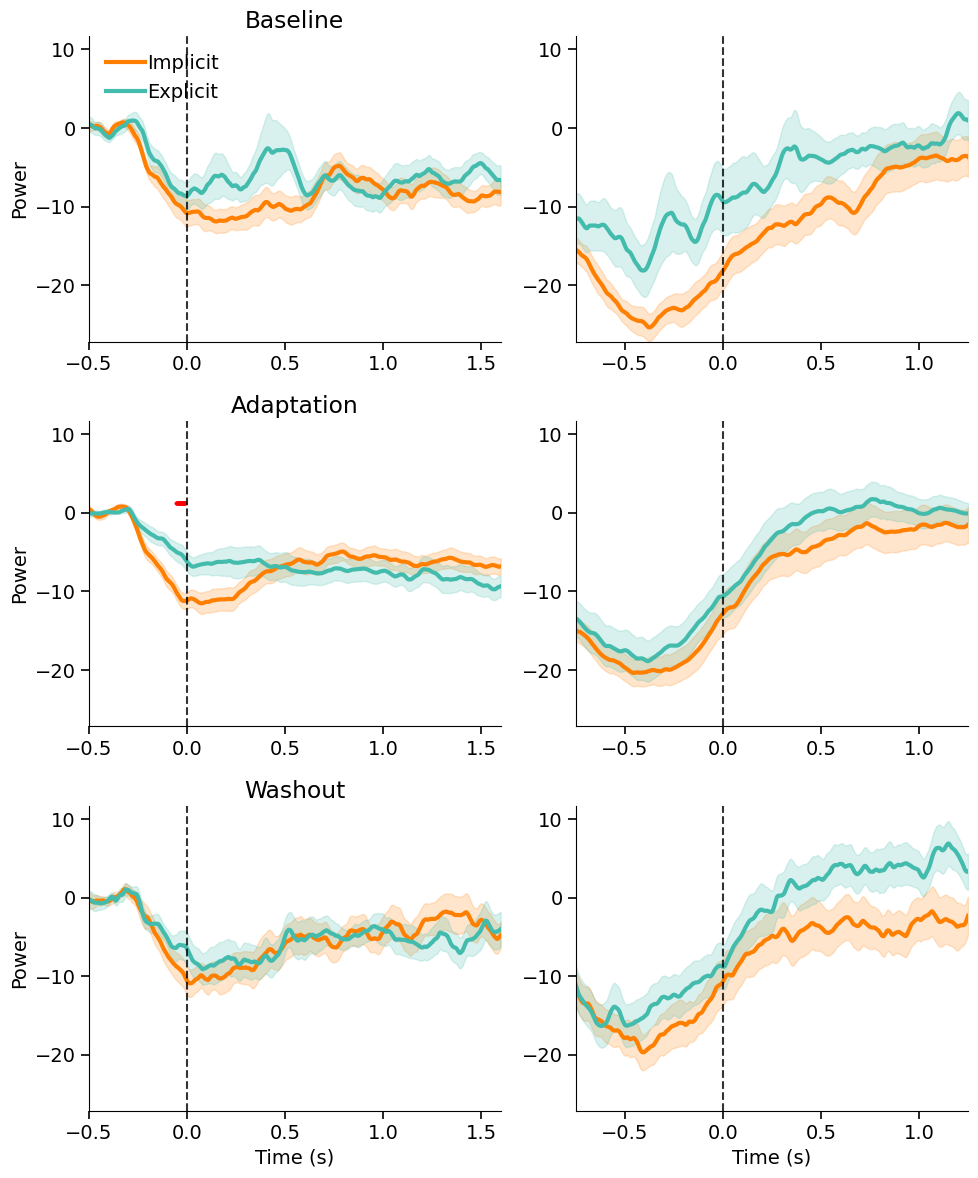

In [12]:
phases = ['baseline', 'adaptation', 'washout']
plot_lims = {'vis': (-0.5, 1.6), 'mot': (-0.75, 1.25)}
durations = {k: plot_lims[k][1] - plot_lims[k][0] for k in ['vis', 'mot']}
total_width = durations['vis'] + durations['mot']
width_ratios = [durations['vis'] / total_width, durations['mot'] / total_width]

# === Compute ylims from mean ± SEM ===
means = []
sems = []
for epoch in ['vis', 'mot']:
    for phase in phases:
        data = power_data[epoch][phase]
        imp_mean = np.nanmean(data['Implicit'], axis=0)
        exp_mean = np.nanmean(data['Explicit'], axis=0)
        imp_sem = sem(data['Implicit'], axis=0, nan_policy='omit')
        exp_sem = sem(data['Explicit'], axis=0, nan_policy='omit')
        means.extend([*imp_mean, *exp_mean])
        sems.extend([*imp_sem, *exp_sem])

means = np.array(means)
sems = np.array(sems)
range_margin = 0.05 * (np.max(means + sems) - np.min(means - sems))
ylims = (
    np.min(means - sems),
    np.max(means + sems) + range_margin
)

# === Plotting ===
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(3, 2, width_ratios=width_ratios)
axes = {}

for i, phase in enumerate(phases):
    for j, epoch in enumerate(['vis', 'mot']):
        ax = fig.add_subplot(gs[i, j])
        axes[(phase, epoch)] = ax
        data = [
            power_data[epoch][phase]['Implicit'],
            power_data[epoch][phase]['Explicit']
        ]
        ylabel = "Power" if j == 0 else ""
        xlabel = "Time (s)" if i == 2 else ""
        title = f"{phase.capitalize()}" if j == 0 else ""
        plot_and_cluster_data_between_group(
            ax, power_time_plots[epoch], data,
            colorbl, title, xlabel, ylabel,
            verbose=False
        )
        ax.set_xlim(*plot_lims[epoch])
        ax.set_ylim(ylims)

axes[('baseline', 'vis')].legend(loc='upper left')
for (phase, epoch), ax in axes.items():
    if not (phase == 'baseline' and epoch == 'vis'):
        ax.get_legend().remove()
    ax.axvline(0, linestyle='--', color='black', alpha=0.8)

plt.tight_layout()
# plt.savefig(f'./figures/{pc}_q{q+1}_burst_rate_grid.pdf', format='pdf', bbox_inches='tight', dpi=600)
# plt.close()


/home/bonaiuto/tmp/ipykernel_63146/3484598395.py:61: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(
/home/bonaiuto/tmp/ipykernel_63146/3484598395.py:61: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(


Significant clusters found!


/home/bonaiuto/tmp/ipykernel_63146/3484598395.py:61: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(


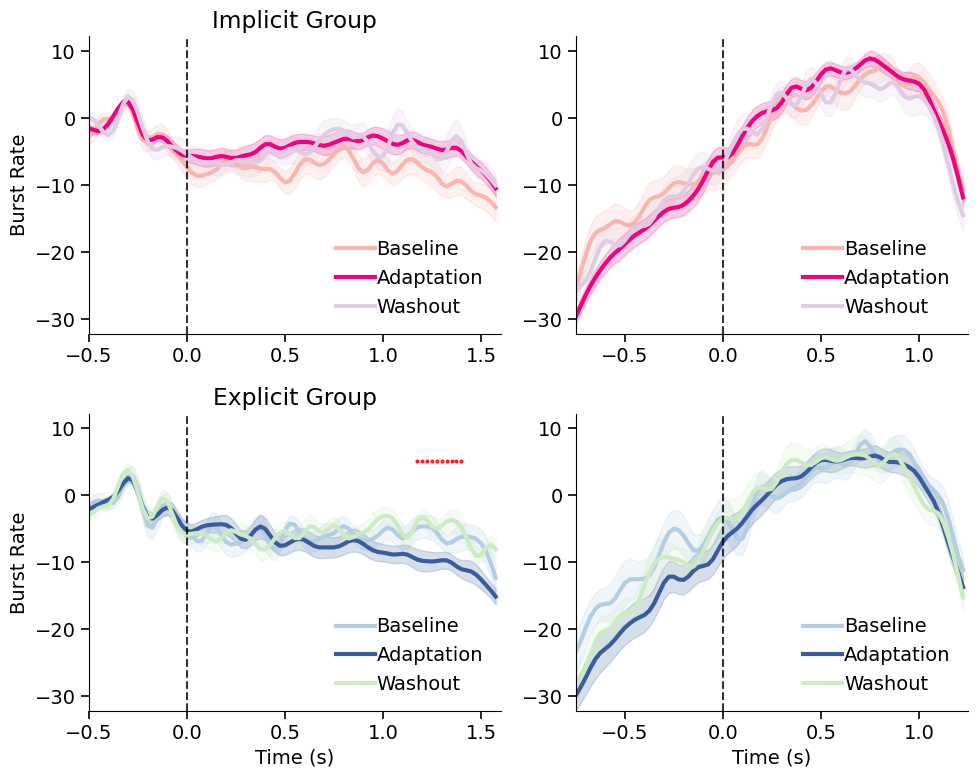

In [13]:
phases = ['baseline', 'adaptation', 'washout']
plot_lims = {'vis': (-0.5, 1.6), 'mot': (-0.75, 1.25)}
durations = {k: plot_lims[k][1] - plot_lims[k][0] for k in ['vis', 'mot']}
total_width = durations['vis'] + durations['mot']
width_ratios = [durations['vis'] / total_width, durations['mot'] / total_width]

# === Compute ylims from mean ± SEM ===
means, sems = [], []
for epoch in ['vis', 'mot']:
    for group in ['Implicit', 'Explicit']:
        for phase in phases:
            data = burst_data[epoch][phase][group]
            mean_curve = np.nanmean(data, axis=0)
            sem_curve = sem(data, axis=0, nan_policy='omit')
            means.extend(mean_curve)
            sems.extend(sem_curve)

means = np.array(means)
sems = np.array(sems)
range_margin = 0.05 * (np.max(means + sems) - np.min(means - sems))
ylims = (
    np.min(means - sems),
    np.max(means + sems) + range_margin
)

# === Plotting ===
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 2, width_ratios=width_ratios)

for i, group in enumerate(['Implicit', 'Explicit']):
    for j, epoch in enumerate(['vis', 'mot']):
        ax = fig.add_subplot(gs[i, j])
        data = [
            burst_data[epoch]['baseline'][group],
            burst_data[epoch]['adaptation'][group],
            burst_data[epoch]['washout'][group]
        ]
        xlabel = "Time (s)" if i == 1 else ""
        ylabel = "Burst Rate" if j == 0 else ""
        title = f"{group} Group" if j == 0 else ""
        color_set = colors_implicit if group == 'Implicit' else colors_explicit

        plot_and_cluster_data_blocktype_within_group(
            ax, rate_time_plots[epoch], data,
            color_set, title, xlabel, ylabel,
            verbose=False
        )
        ax.set_xlim(*plot_lims[epoch])
        ax.set_ylim(ylims)

for ax in fig.axes:
    ax.axvline(0, linestyle='--', color='black', alpha=0.8)

plt.tight_layout()
# plt.savefig(f'./figures/{pc}_q{q+1}_within_group_blocktype.pdf', format='pdf', bbox_inches='tight', dpi=600)
# plt.close()


/home/bonaiuto/tmp/ipykernel_63146/3484598395.py:61: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(
/home/bonaiuto/tmp/ipykernel_63146/3484598395.py:61: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(


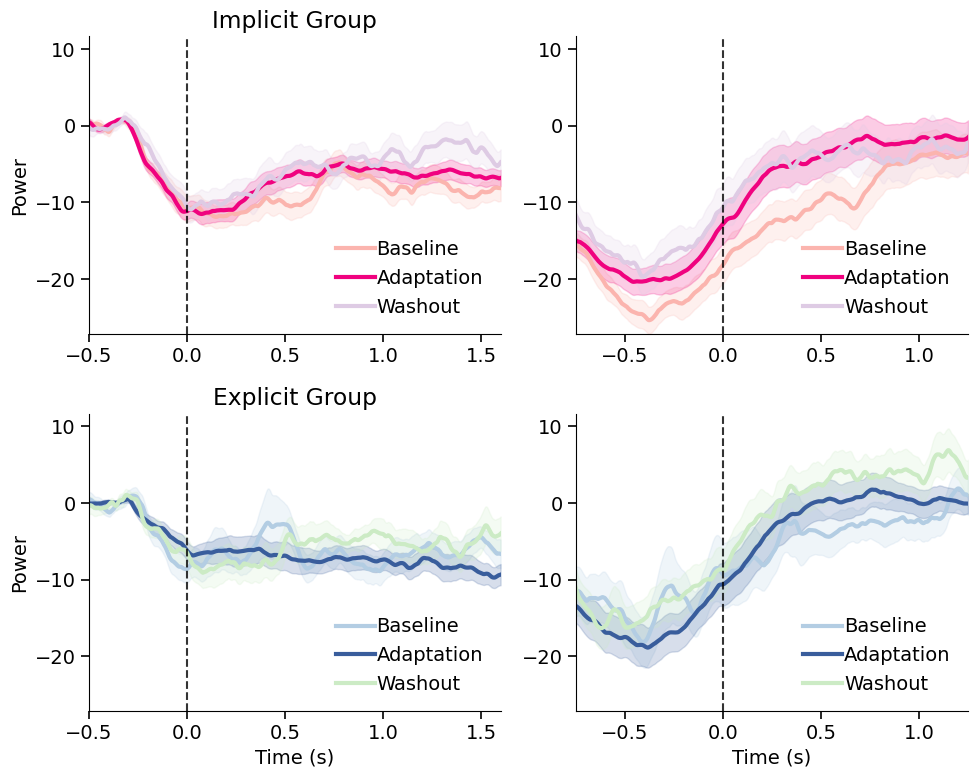

In [14]:
phases = ['baseline', 'adaptation', 'washout']
plot_lims = {'vis': (-0.5, 1.6), 'mot': (-0.75, 1.25)}
durations = {k: plot_lims[k][1] - plot_lims[k][0] for k in ['vis', 'mot']}
total_width = durations['vis'] + durations['mot']
width_ratios = [durations['vis'] / total_width, durations['mot'] / total_width]

# === Compute ylims from mean ± SEM ===
means, sems = [], []
for epoch in ['vis', 'mot']:
    for group in ['Implicit', 'Explicit']:
        for phase in phases:
            data = power_data[epoch][phase][group]
            mean_curve = np.nanmean(data, axis=0)
            sem_curve = sem(data, axis=0, nan_policy='omit')
            means.extend(mean_curve)
            sems.extend(sem_curve)

means = np.array(means)
sems = np.array(sems)
range_margin = 0.05 * (np.max(means + sems) - np.min(means - sems))
ylims = (
    np.min(means - sems),
    np.max(means + sems) + range_margin
)

# === Plotting ===
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 2, width_ratios=width_ratios)

for i, group in enumerate(['Implicit', 'Explicit']):
    for j, epoch in enumerate(['vis', 'mot']):
        ax = fig.add_subplot(gs[i, j])
        data = [
            power_data[epoch]['baseline'][group],
            power_data[epoch]['adaptation'][group],
            power_data[epoch]['washout'][group]
        ]
        xlabel = "Time (s)" if i == 1 else ""
        ylabel = "Power" if j == 0 else ""
        title = f"{group} Group" if j == 0 else ""
        color_set = colors_implicit if group == 'Implicit' else colors_explicit

        plot_and_cluster_data_blocktype_within_group(
            ax, power_time_plots[epoch], data,
            color_set, title, xlabel, ylabel,
            verbose=False
        )
        ax.set_xlim(*plot_lims[epoch])
        ax.set_ylim(ylims)

for ax in fig.axes:
    ax.axvline(0, linestyle='--', color='black', alpha=0.8)

plt.tight_layout()
# plt.savefig(f'./figures/{pc}_q{q+1}_within_group_blocktype.pdf', format='pdf', bbox_inches='tight', dpi=600)
# plt.close()


Significant clusters found!
Significant clusters found!


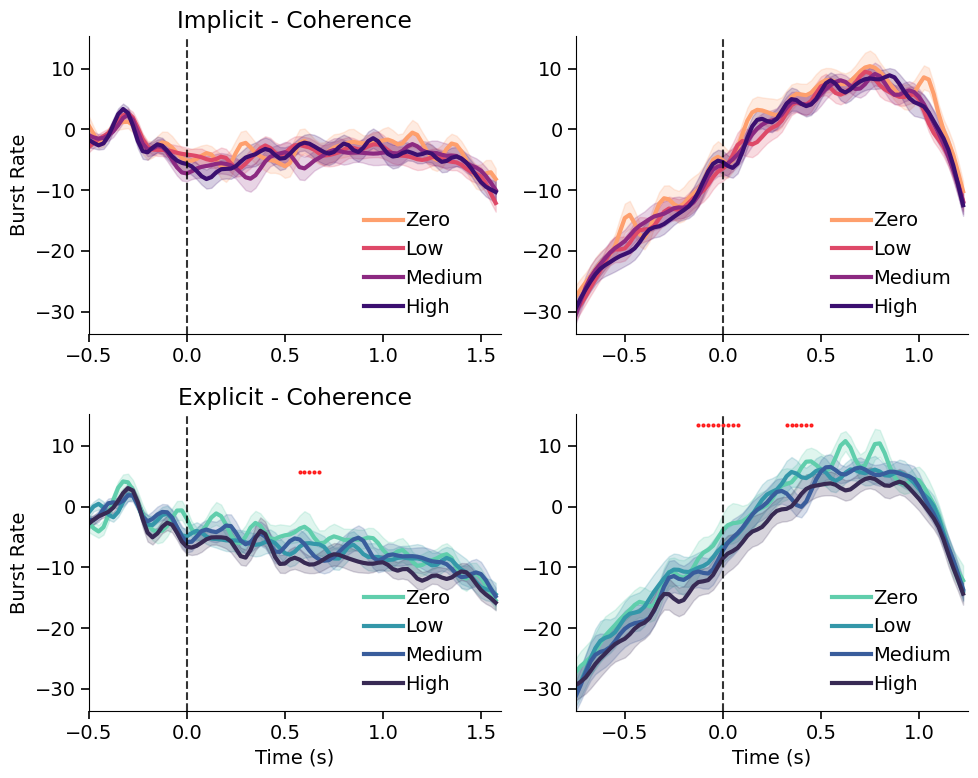

In [15]:
cohcats = ['zero', 'low', 'med', 'high']
plot_lims = {'vis': (-0.5, 1.6), 'mot': (-0.75, 1.25)}
durations = {k: plot_lims[k][1] - plot_lims[k][0] for k in ['vis', 'mot']}
total_width = durations['vis'] + durations['mot']
width_ratios = [durations['vis'] / total_width, durations['mot'] / total_width]

# === Compute ylims for this quartile ===
means, sems = [], []
for epoch in ['vis', 'mot']:
    for group in ['Implicit', 'Explicit']:
        for coh in cohcats:
            data = coh_burst_data[epoch][coh][group]
            mean_curve = np.nanmean(data, axis=0)
            sem_curve = sem(data, axis=0, nan_policy='omit')
            means.extend(mean_curve)
            sems.extend(sem_curve)

means = np.array(means)
sems = np.array(sems)
range_margin = 0.05 * (np.max(means + sems) - np.min(means - sems))
ylims = (
    np.min(means - sems),
    np.max(means + sems) + range_margin
)

# === Plotting ===
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 2, width_ratios=width_ratios)

for i, group in enumerate(['Implicit', 'Explicit']):
    for j, epoch in enumerate(['vis', 'mot']):
        ax = fig.add_subplot(gs[i, j])
        data = [
            coh_burst_data[epoch]['zero'][group],
            coh_burst_data[epoch]['low'][group],
            coh_burst_data[epoch]['med'][group],
            coh_burst_data[epoch]['high'][group]
        ]
        xlabel = "Time (s)" if i == 1 else ""
        ylabel = "Burst Rate" if j == 0 else ""
        title = f"{group} - Coherence" if j == 0 else ""
        colors = colors4 if group == 'Implicit' else colors5

        plot_and_cluster_data_coh(
            ax, rate_time_plots[epoch], data,
            colors, title, xlabel, ylabel,
            verbose=False
        )
        ax.set_xlim(*plot_lims[epoch])
        ax.set_ylim(ylims)

for ax in fig.axes:
    ax.axvline(0, linestyle='--', color='black', alpha=0.8)

plt.tight_layout()
# plt.savefig(f'./figures/{pc}_q{q+1}_coherence_effects.pdf', format='pdf', bbox_inches='tight', dpi=600)
# plt.close()


Significant clusters found!


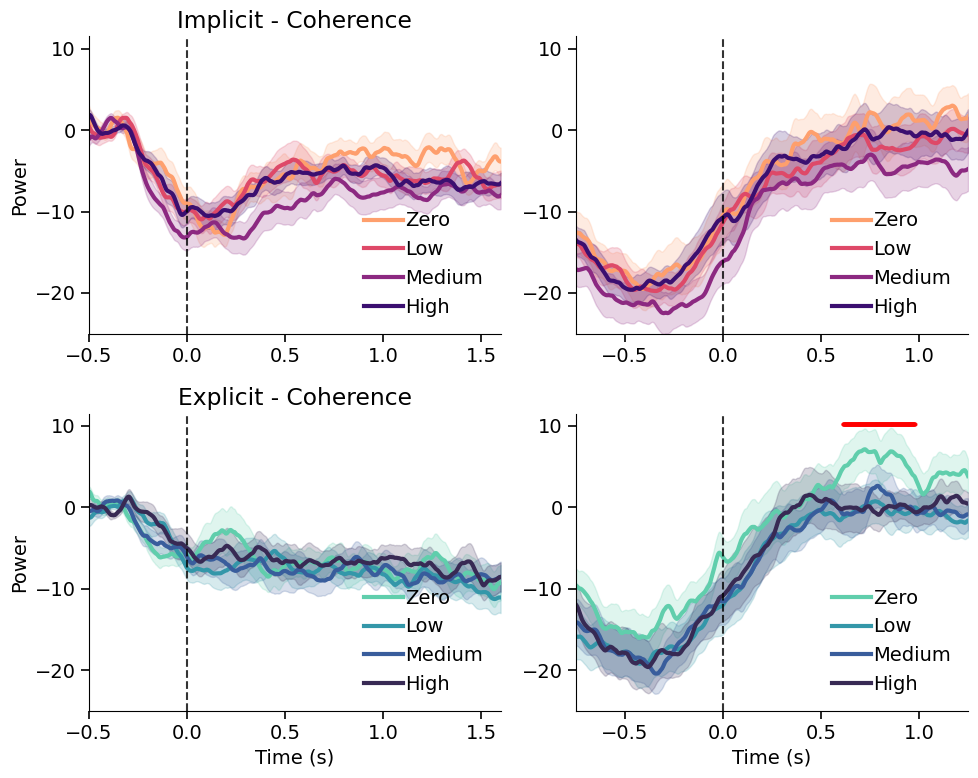

In [16]:
cohcats = ['zero', 'low', 'med', 'high']
plot_lims = {'vis': (-0.5, 1.6), 'mot': (-0.75, 1.25)}
durations = {k: plot_lims[k][1] - plot_lims[k][0] for k in ['vis', 'mot']}
total_width = durations['vis'] + durations['mot']
width_ratios = [durations['vis'] / total_width, durations['mot'] / total_width]

# === Compute ylims for this quartile ===
means, sems = [], []
for epoch in ['vis', 'mot']:
    for group in ['Implicit', 'Explicit']:
        for coh in cohcats:
            data = coh_power_data[epoch][coh][group]
            mean_curve = np.nanmean(data, axis=0)
            sem_curve = sem(data, axis=0, nan_policy='omit')
            means.extend(mean_curve)
            sems.extend(sem_curve)

means = np.array(means)
sems = np.array(sems)
range_margin = 0.05 * (np.max(means + sems) - np.min(means - sems))
ylims = (
    np.min(means - sems),
    np.max(means + sems) + range_margin
)

# === Plotting ===
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 2, width_ratios=width_ratios)

for i, group in enumerate(['Implicit', 'Explicit']):
    for j, epoch in enumerate(['vis', 'mot']):
        ax = fig.add_subplot(gs[i, j])
        data = [
            coh_power_data[epoch]['zero'][group],
            coh_power_data[epoch]['low'][group],
            coh_power_data[epoch]['med'][group],
            coh_power_data[epoch]['high'][group]
        ]
        xlabel = "Time (s)" if i == 1 else ""
        ylabel = "Power" if j == 0 else ""
        title = f"{group} - Coherence" if j == 0 else ""
        colors = colors4 if group == 'Implicit' else colors5

        plot_and_cluster_data_coh(
            ax, power_time_plots[epoch], data,
            colors, title, xlabel, ylabel,
            verbose=False
        )
        ax.set_xlim(*plot_lims[epoch])
        ax.set_ylim(ylims)

for ax in fig.axes:
    ax.axvline(0, linestyle='--', color='black', alpha=0.8)

plt.tight_layout()
# plt.savefig(f'./figures/{pc}_q{q+1}_coherence_effects.pdf', format='pdf', bbox_inches='tight', dpi=600)
# plt.close()
